In [2]:
from data_loading.data import LoadingData
from Models.arima.arima import ARIMA
from ts_tools.tools import tools

[*********************100%%**********************]  1 of 1 completed


Getting info for ticker AAPL...


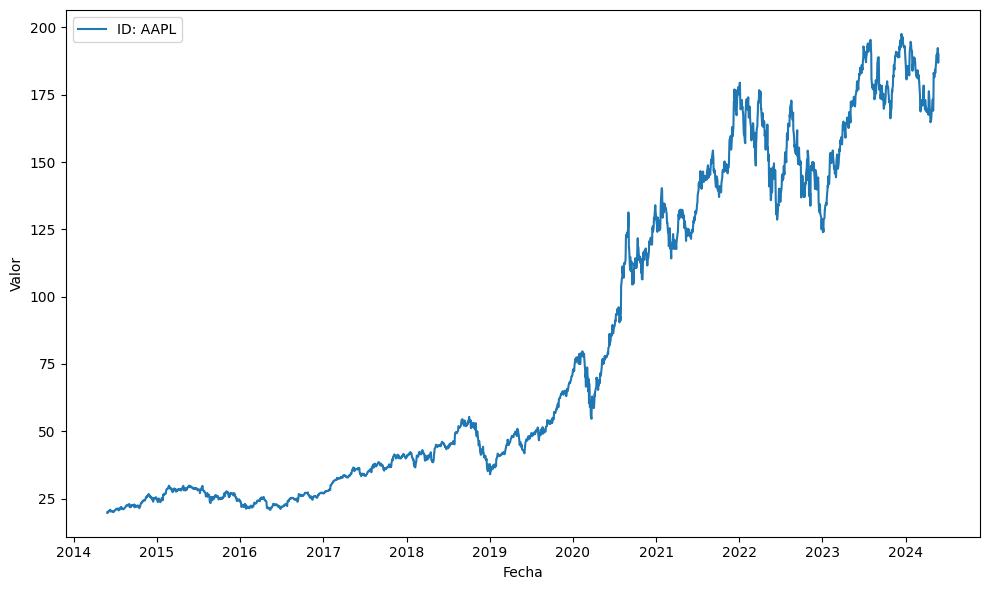

In [3]:
loader = LoadingData(tickers=['AAPL'])
ts = loader.get_data()
info = loader.get_info_ticker()

ts_tools = tools()
ts = ts_tools.ts_prepartion(ts, 'Date', 'Adj Close')
ts_tools.plot(ts)

In [8]:
# Definir los argumentos para ARIMA
order = '1, 1, 1'  # Por ejemplo, orden (p, d, q)

# Crear una instancia del modelo ARIMA
model = ARIMA(order)

# Ajustar el modelo ARIMA a los datos históricos
model.fit(train_x)

# Hacer predicciones
predictions = model.predict(test_x)


AttributeError: 'str' object has no attribute 'order'